<a href="https://colab.research.google.com/github/ioanabuze/Data-Engineering_W4/blob/master/MSIN0166_Group_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction

The scope of this project is to use Snorkel DryBell generative approach to produce a set of weak labels for a chosen dataset.

The proposed dataset consists of Amazon Consumer Reviews of Amazon Products (Data.world, 2020). The aim is to train a classifier over the review data that can predict whether reviews are positive, negative or neutral. The attitudes of user reviews play an important role in marketing analytics.

We have access to both the review text and the review rating for the project. The rating will be removed and kept aside as gold labels so that we can check the accuracy of our work. For training a classifier, we will label the data. However, hand-labelling tens of thousand of data points is generally slow and costly. Therefore, we will use a weak supervision approach using labelling functions in Snorkel. This are noisy, programmatically rules and heuristics that appoint labels to unlabelled training data (Snorkel.org, 2020).

The reviews dataset contains a ratings column for each Amazon product, which rates products from 1 (really bad) to 5 (very good). In business, whether the content is positive or negative matters more than the exact rating. Thus, we will look at this rating and tran a model which classifies review text as positive, negative or neutral.

As such, two labelling functions will be created to determine whether positive reviews are contained in the last 2 rating tiers, negative reviews are contained in the first two rating tiers and neutral reviews are contained in the third rating tier. The most common positive, negative and neutral words that were identified in the dataset will be used to determine the type of review. These labels will be then used as a basis descriminative model, will be trained to further enhance the model performance and will further be used to evaluate the accuracy of the combination of the models (Medium, 2020a).


## 2. Installing Libraries and Setup

We will start by installing and importing all the necessary libraries (Nltk.org, 2020).

In [1]:
!pip install snorkel

     |████████████████████████████████| 143kB 2.8MB/s 
     |████████████████████████████████| 676.9MB 25kB/s 
     |████████████████████████████████| 6.7MB 34.3MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 194kB 54.7MB/s 
     |████████████████████████████████| 1.8MB 46.4MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=787378ff2962d833eab053c7901887ea08de4dab8ab2ca0900eafe35f68b8c6a
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: sc

In [2]:
import nltk
nltk.download("popular")
nltk.download('vader_lexicon')
nltk.download('brown')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [3]:
# pyspark setup

!pip install pyspark
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive")

     |████████████████████████████████| 217.8MB 61kB/s 
     |████████████████████████████████| 204kB 48.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=4b2edea892707d4afb5d552fbb6e8e82e06d7d106637747c75d0c1d77275adb4
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#Setup the correct path
cd "/content/drive/My Drive/Colab Notebooks/Group_Project"

/content/drive/My Drive/Colab Notebooks/Group_Project


In [5]:
from snorkel.labeling.apply.spark import SparkLFApplier
from snorkel.labeling import MajorityLabelVoter
from snorkel.labeling import labeling_function, LFAnalysis, LabelModel, PandasLFApplier
from snorkel.preprocess import preprocessor
from snorkel.labeling import filter_unlabeled_dataframe
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

import nltk
import re
import string
import spacy

from functools import reduce
from wordcloud import WordCloud
from textblob import TextBlob 
import pyspark.sql.functions as f
from textblob import TextBlob

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

from snorkel.utils import probs_to_preds

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
import os 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

COLAB_NOTEBOOKS_DATA_PATH="/content/drive/My Drive/Colab Notebooks/Group_Project"
SPARK_ARCHIVE='spark-2.4.5-bin-hadoop2.7.tgz'
if SPARK_ARCHIVE not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

SPARK_ARTIFACTS='spark-2.4.5-bin-hadoop2.7'
if SPARK_ARTIFACTS not in os.listdir(COLAB_NOTEBOOKS_DATA_PATH):
  !tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/Colab Notebooks/Group_Project/spark-2.4.5-bin-hadoop2.7"

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import findspark
findspark.init()

import pyspark
from pyspark.sql import SQLContext

In [0]:
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

## 3. Load Data

Due to the issue of this csv file, we load the Amazon reviews into pandas. We make a subset of our DataFrame using pandas and keep only the columns we need. We also rename the columns: "reviews.rating" to "reviews_rating" and "reviews.text" to "reviews_text" for selecting them in SparkSQL. Then, we convert the pandas DataFrame to a Spark DataFrame which we finally convert to a Spark Resilient Distributed Datasets (RDD).

In [0]:
# Load the Data

# Switch this back to Spark once we figure out the CSV formatting issue
amazon_reviews_dataset_pd_df = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
amazon_reviews_dataset_pd_df = pd.concat([amazon_reviews_dataset_pd_df['reviews.rating'],amazon_reviews_dataset_pd_df['reviews.text']], axis=1)
amazon_reviews_dataset_pd_df = amazon_reviews_dataset_pd_df.dropna()
amazon_reviews_dataset_pd_df.rename(columns={"reviews.rating": "reviews_rating", "reviews.text": "reviews_text"}, inplace=True)
amazon_reviews_dataset_pd_df

# Convert pandas DF to spark dataframe
amazon_reviews_dataset_sql_context = sqlContext.createDataFrame(amazon_reviews_dataset_pd_df)
amazon_reviews_dataset_sql_context = amazon_reviews_dataset_sql_context.dropna(subset=["reviews_rating", "reviews_text"])

# Convert spark dataframe to RDD
amazon_reviews_dataset_rdd = amazon_reviews_dataset_sql_context.rdd

We need to create a temporary view in order to manipulate the data using SQL queries. To go further, we will be spliting the review text by review/levels, these will be the basis for learning information about the data that can be used for creating heuristics for our labeling functions.

In [0]:
 # Temp view for maniputing the data using SQL queries
amazon_reviews_dataset_sql_context.createOrReplaceTempView('amazon_reviews')

amazon_reviews_level1 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 1")
amazon_reviews_level2 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 2")
amazon_reviews_level3 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 3")
amazon_reviews_level4 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 4")
amazon_reviews_level5 = sqlContext.sql("SELECT reviews_text FROM amazon_reviews where reviews_rating == 5")

## 4. Exploratory Data Analysis 

The exploratory analysis was performed on Pandas DataFrames in order to leverage the variety and flexibility of the libraries when looking for insights.  

**Class imbalance**

By looking at the total number of reviews per rating, one can observe that almost 70% of the reviews have a rating of 5 stars, and 24% of 4 stars rating, whereas only 1-3% for 1, 2 and 3 stars rating. Therefore, this leads to signifficant class inbalance.

5    69.56%
4    24.16%
3     3.94%
1     1.26%
2     1.08%
Name: reviews_rating, dtype: object


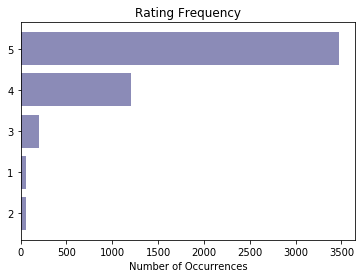

In [12]:
ratings = amazon_reviews_dataset_pd_df['reviews_rating'].value_counts().sort_values(ascending=True ) 
print(amazon_reviews_dataset_pd_df['reviews_rating'].value_counts(normalize=True).sort_values(ascending=False ).map(lambda x: x*100).round(2).astype(str) + '%')
objects = ratings.keys() 
y_pos = np.arange(len(objects)) 
rating_values = ratings.values 
plt.barh(y_pos, rating_values, align='center', alpha=0.5, color = "midnightblue") 
plt.yticks(y_pos, objects) 
plt.xlabel('Number of Occurrences') 
plt.title('Rating Frequency') 
plt.show()

**Most frequent words**

We will now step into exploring the dataset for initial ideas.

Because frequent words appearing in the reviews do not contribute to sentimential analysis, such as stop words (Dataquest, 2020), we will only look for **adjectives**.

We find the most frequent adjectives (A Data Analyst, 2020; Medium, 2020b) and show the result using wordcloud(python and S, 2020).


In [0]:
# Create functions to return top 15 words by frequency 

def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(15)) for tag in cfd.conditions())

def top15_frequent_adjectives(txt):
  tagdict = findtags('JJ', nltk.pos_tag(txt))
  list_with_words = []
  for tag in sorted(tagdict):
    for othertag in tagdict[tag]:
      list_with_words.append(othertag)
  return(list_with_words)

def wondcloud_func(df):
  d = {}
  for a, x in df:
    d[a] = x
  wordcloud = WordCloud()
  return wordcloud.generate_from_frequencies(frequencies=d)
  plt.figure()

We apply the above function to all the review levels. This is done to determine the most common positive, negative and neutral adjectives in each review level. This words will be used to create our labelling functions.

For each review level which will be later categorized as negative, the most common adjectives are the following:

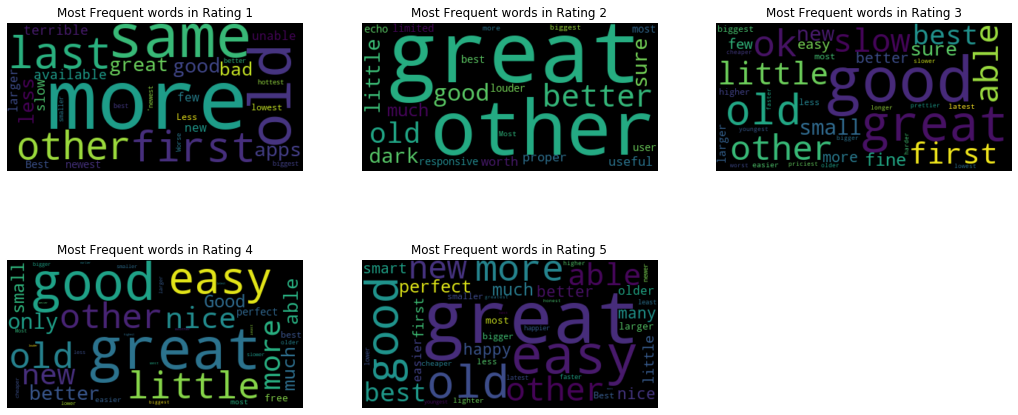

In [20]:
txt1 = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level1.select('reviews_text').collect()))
txt2 = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level2.select('reviews_text').collect()))
txt3 = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level3.select('reviews_text').collect()))
txt4 = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level4.select('reviews_text').collect()))
txt5 = word_tokenize(' '.join(row.reviews_text for row in amazon_reviews_level5.select('reviews_text').collect()))

list_with_texts = [txt1, txt2, txt3, txt4, txt5]

fig = plt.figure(figsize=(18,8))

countt = 1 

for text in list_with_texts:
  ax = fig.add_subplot(2,3,countt)
  wordcloud = wondcloud_func(top15_frequent_adjectives(text))
  ax.imshow(wordcloud, interpolation="bilinear")
  title_name = "Most Frequent words in Rating " + str(countt)
  ax.set_title(title_name)
  countt+=1
  ax.axis('off')


The above wordclouds look at the most frequent adjectives used in the text reviews. For our labelling functions we will use these words as guidance for categorising the positive, negative and neutral reviews. Surprisingly, there is a vast amount of words which are frequently used in more than one category, such as “great”, “good”, “old”. However, their occurrence in intuitively “the wrong categories” should not be surprising, because this analysis does not include any other phrasing components, such as verbs or negations. Therefore, we cannot draw certain analytical conclusions based on them, however, we must use them as guidance for our intuition when creating the weak labelling.



## 5. Writing Labeling Functions (LFs)

We will now move forward with our analysis to splitting the data into two subsets:

<b>Training Set:</b> this will contain the largest amount of data points from the dataset; for which we will create labels through weak supervision.

<b>Test Set:</b> this will contain only a standard, small hold-out blind hand-labeled set; which will be used for final evaluation of our classifier.

80% of our reviews are combined to create the train set, while 20% of our reviews are combined to create the test set.

In [0]:
# Train/Test Split - 80/20 
df_train, df_test = amazon_reviews_dataset_rdd.randomSplit([0.8, 0.2], seed=42)

# Code to convert our y_test values into positive/negative and neutral and convert it to series, as input for the 
#accuracy comparision later as the Majority Accuaracy function needs input as numpy. 

Y_test = df_test.toDF()
Y_test = Y_test.toPandas()

Y_test.loc[Y_test['reviews_rating'] == 1, 'reviews_rating'] = 0
Y_test.loc[Y_test['reviews_rating'] == 2, 'reviews_rating'] = 0
Y_test.loc[Y_test['reviews_rating'] == 3, 'reviews_rating'] = 2
Y_test.loc[Y_test['reviews_rating'] == 4, 'reviews_rating'] = 1
Y_test.loc[Y_test['reviews_rating'] == 5, 'reviews_rating'] = 1

Y_test = Y_test['reviews_rating']

The main aim for developing labelling functions is to develop a high quality set of training labels for the Amazon reviews dataset which is unlabelled. The labels for the training set are utilized to train a different discriminative model. This is done in order to generalize to novel, unseen data points. By utilizing this model, we will be able to create certain predictions for the data points that are not covered by our labelling functions.

First, we define constants to represent the class labels for negative, positive and neutral reviews(GitHub, 2020).

We define constants to represent the class labels for: 

- NEGATIVE = 0
- POSITIVE = 1
- NEUTRAL = 2
- ABSTAIN = -1

In [0]:
# Set voting values

NEGATIVE = 0
POSITIVE = 1
NEUTRAL = 2

ABSTAIN = -1

Based on our analysis above, we identified the most frequent adjectives when giving different reviews. To be noticed that because of the words popularity in multiple categories, we used a “rule of thumb” when choosing which words better describe a certain category. Therefore, we decided upon the following words for the labeling function.

In [0]:
ReviewNEGATIVE =  r"(same|old|bad|slow|terrible|unable|few|worse|less|worse|limited)"


ReviewNEUTRAL = r"(ok|fine)" 


ReviewPOSITIVE = r"(great|good|easy|reliable|nice|new|perfect|better|happy)" 


We will now write labelling functions to determine whether positive reviews are contained in the last two rating tiers, negative reviews are contained in the first two rating tiers and neutral reviews are contained in the third tier.

In [0]:
# labelling functions based off specific words
@labeling_function()
def review_NEGATIVE(x):
      return NEGATIVE if re.search(ReviewNEGATIVE, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_NEUTRAL(x):
    return NEUTRAL if re.search(ReviewNEUTRAL, x.reviews_text.lower()) else ABSTAIN

@labeling_function()
def review_POSITIVE(x):
    return POSITIVE if re.search(ReviewPOSITIVE, x.reviews_text.lower()) else ABSTAIN

## 6. Writing More Labeling Functions

The next heuristic that we are looking at is the number of word that the unhappy customers write to understand if there is a significant difference 
between our five rating levels.

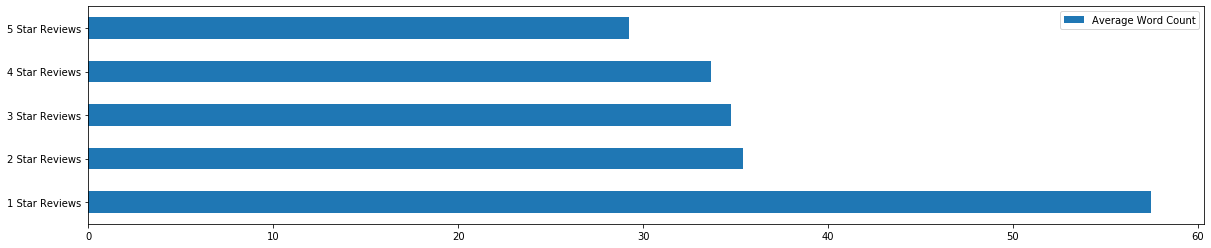

In [0]:
def get_avg_wordcount(DF):
  df = DF.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' ')))
  totalwords = df.groupBy().sum().collect()[0][0]
  colcount = DF.count()
  avgwordcount = totalwords/colcount
  return avgwordcount

pandD = pd.DataFrame(data = [get_avg_wordcount(amazon_reviews_level1),
                             get_avg_wordcount(amazon_reviews_level2),
                             get_avg_wordcount(amazon_reviews_level3),
                             get_avg_wordcount(amazon_reviews_level4),
                             get_avg_wordcount(amazon_reviews_level5)], columns=['Average Word Count'], index=['1 Star Reviews',
                                                                                                              '2 Star Reviews',
                                                                                                              '3 Star Reviews',
                                                                                                              '4 Star Reviews',
                                                                                                              '5 Star Reviews'])
                             
pandD.plot.barh(figsize=(20,4))

(0, 125)

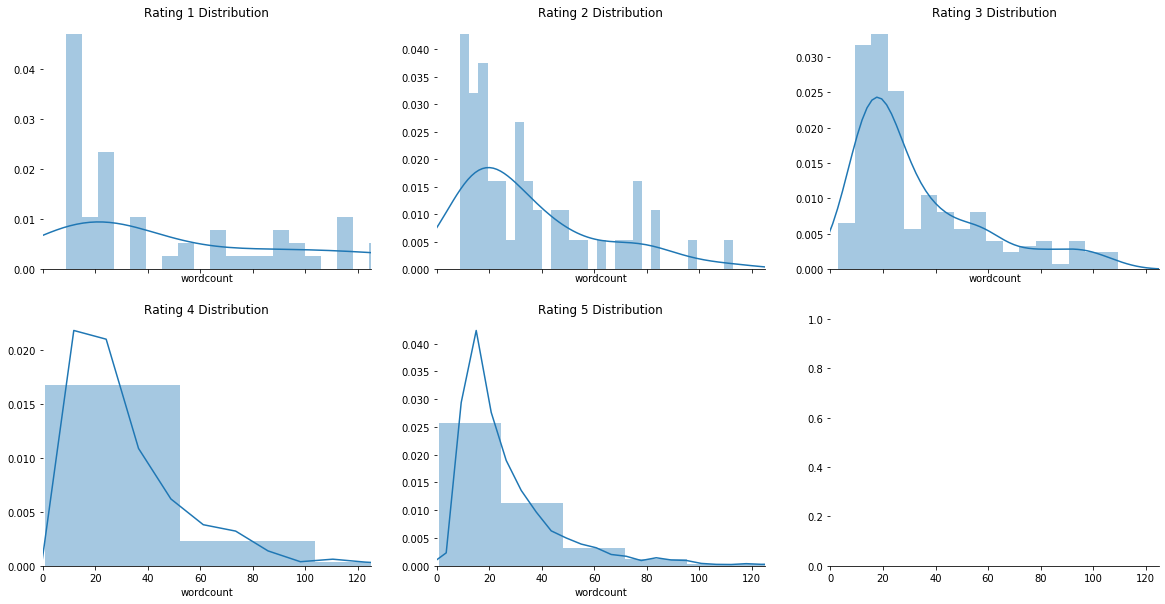

In [0]:
am_rev_wordcount1= amazon_reviews_level1.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()
am_rev_wordcount2= amazon_reviews_level2.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()
am_rev_wordcount3= amazon_reviews_level3.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()
am_rev_wordcount4= amazon_reviews_level4.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()
am_rev_wordcount5= amazon_reviews_level5.withColumn('wordCount', f.size(f.split(f.col('reviews_text'), ' '))).select('wordcount').toPandas()

figuresssss, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(am_rev_wordcount1['wordcount'], bins=30, kde=True, ax=axes[0, 0])
sns.distplot(am_rev_wordcount2['wordcount'], bins=30, kde=True, ax=axes[0, 1])
sns.distplot(am_rev_wordcount3['wordcount'], bins=30, kde=True, ax=axes[0, 2])
sns.distplot(am_rev_wordcount4['wordcount'], bins=30, kde=True, ax=axes[1, 0])
sns.distplot(am_rev_wordcount5['wordcount'], bins=30, kde=True, ax=axes[1, 1])
axes[0, 0].set_title("Rating 1 Distribution")
axes[0, 1].set_title("Rating 2 Distribution")
axes[0, 2].set_title("Rating 3 Distribution")
axes[1, 0].set_title("Rating 4 Distribution")
axes[1, 1].set_title("Rating 5 Distribution")
plt.xlim(0, 125)

What clearly stands out with these graphs is that people that write 5 star reviews for example tend to use less words. On average 5 star reviews are composed of 30 words whilst 1 star reviews possess around 55+.  That can logically be explained. When customer are satisfied less words are needed. A simple “great” , “fantastique product” is enough. However, When customers are not satisfied with the product, they will explain their issue and why they dislike the product hens the longer reviews. 

Another point highlighted in the graphs is an overlapping issue. We will have to be careful when setting  the word count for our  labelling function to capture a maximum of positive and negative reviews. However because of the overlapping, some reviews will be miss-matched if we would only use this labelling function.

In [0]:
@labeling_function()
def pos_string_length(x):
  return POSITIVE if len(x.reviews_text.split()) <= 30 else ABSTAIN

In [0]:
@labeling_function()
def neg_string_length(x):
  return NEGATIVE if len(x.reviews_text.split()) >= 40 else ABSTAIN

We will now move forward with out analysis and start writting a labelling function that uses a third-party model. For this, we will use the TextBlob tool which supplies a pretrained sentiment analyzer (Textblob.readthedocs.io, 2020). The function looks at the amount of feelings based on the text itself. It is believed to bring more accuracy in voting, as it looks at the overall context of the review. 

First, we develope a function that runs TextBlob on our review comments and obtains the polarity scores.

In [0]:
def getSentiment(text):
    x = {}
    x["polarity"] = TextBlob(text).sentiment.polarity
    x["subjectivity"] = TextBlob(text).sentiment.subjectivity 
    return x

Then, we create a labelling function to identify if:

- Positive reviews have a polarity score of 0.2 or above;
- Neutral reviews have a polarity score of -0.2 or above;
- Negative reviews have a polarity score of less than 0.2.

In [0]:
@labeling_function()
def textblob_polarity(x):
    x = getSentiment(x.reviews_text)

    if x["polarity"] >= 0.2:
      return POSITIVE 
    if x["polarity"] >= -0.2:
      return NEUTRAL
    if x["polarity"] < -0.2:
      return NEGATIVE
    else:
      return ABSTAIN

## 7. Labelling, Analysis and Accuracy

We must now use the LabelModel to programmatically learn to combine our labelling functions' outputs into strong probabilistic labels. After analyzing different combinations of the previously labelling functions, we decided to keep the combination of labelling functions that in the end gave us the best accuracy score.

In [0]:
# Kept the the combination of lablling functions that give us the best accuracy score
labelingfunctions = [review_NEUTRAL, review_POSITIVE, textblob_polarity, pos_string_length]

To apply the combination of labelling functions to the collection of data points, we need to use an LFApplier. In this case, we used the SparkLFApplier because our data points are represented with a RDD.

In [0]:
applier = SparkLFApplier(lfs=labelingfunctions)

L_train = applier.apply(data_points=df_train)
L_test = applier.apply(data_points=df_test)

By using Snorkel's LFAnalysis utility, we were able to report the following summary statistics for multiple LFs at once:

- Polarity: The set of unique labels this labelling function outputs
- Coverage: The percentage of the dataset the labelling function labels
- Overlaps: The percentage of the dataset where this labelling functions and at least one other labelling functions label
- Conflicts: The percentage of the dataset where this labelling function and at least one other labelling function label and disagree (Snorkel.org, 2020).

These scores helped us decide which combination of labelling functions to keep in order to get a higher accuracy score.

In [0]:
LFAnalysis(L=L_train, lfs=labelingfunctions).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
review_NEGATIVE,0,[0],0.176574,0.176574,0.175571
review_NEUTRAL,1,[2],0.164535,0.164535,0.156759
review_POSITIVE,2,[1],0.603210,0.603210,0.223476
textblob_polarity,3,"[0, 1, 2]",1.000000,0.947580,0.419363
pos_string_length,4,[1],0.697015,0.697015,0.252571


Based on multiple trials, we discovered the labels which bring the most information, have good coverage, whilst having a fairly low conflict. 
Therefore, “review_NEGATIVE” was the only one removed as it was not providing good coverage. Furthermore, it brought significant conflict which subsequently hindered the performance of the overall model.

Now, our aim is to adapt the labels into a single probabilistic  label per data point. The majority voting per data point (Snorkel.readthedocs.io, 2020) will be used as a baseline.

In [0]:
majority_model = MajorityLabelVoter(cardinality=5)
preds_train = majority_model.predict(L=L_train)

The following LabelModel combines the outputs of the labelling functions. This single set of labels will be used to train a classifier.

In [0]:
label_model = LabelModel(cardinality=5, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [0]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   80.8%
Label Model Accuracy:     66.1%


The output of LabelModel is probabilistic in nature. The following histogram shows the confidence level that each data point has the right label - positive/negative/neutral. The most uncertain ponts will have their labels to 0.5.

In [0]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("TBC")
    plt.ylabel("Number of data points")
    plt.show()

probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, POSITIVE])
plot_probabilities_histogram(probs_train[:, NEGATIVE])
plot_probabilities_histogram(probs_train[:, NEUTRAL])

Then, we must convert the DataFrame to Pandas to get the following code working and to prepare for training the classifier.

In [0]:
# Convert the df_train to Pandas to get the code below working and to prep for training the model

df_train = df_train.toDF()
df_train = df_train.toPandas()

df_test = df_test.toDF()
df_test = df_test.toPandas()

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(X=df_train, y=probs_train, L=L_train)

# 8. Training a Classifier

Finally, we are to train a classfier to obtain the accuracy score of the combination of models(Spark.apache.org, 2020).

In [0]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils
# print(df_train)

Through the "probs_to_preds" method, we can change each label distribution with the label of the class that has the maximum level of probability.

In [0]:
# use a simple “bag of n-grams” feature representation
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.reviews_text.tolist())
X_test = vectorizer.transform(df_test.reviews_text.tolist())

In [0]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

Then we can easily use these labels to train a classifier.

In [0]:
from sklearn.naive_bayes import MultinomialNB
sklearn_model = MultinomialNB()
sklearn_model.fit(X=X_train, y=preds_train_filtered)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 86.4%


We observe an increase in the accuracy score compared to the above LabelModel. That is because:

- the discriminative model generalizes beyond the labels of the labeling functions;
- creates accurate predictions on all data points (while the LabelModel creates accurate predictions on only the data points covered by labeling functions).

We are to utilize a label model to pass the domain knowledge encoded in our labelling functions to the discriminative model so that we would be able to generalize beyond the noisy labelling heuristics.

# 9. Summary and Conclusions

The scope of the project was to create a weak labelling model which can identify positive, negative and neutral review ratings of a dataset containing Amazon products. 

Throughout the project a combination of Panda and Pyspark libraries were used. Pandas were leveraged primarily for data exploration, whereas PySpark was primarily used for data processing, assuring high performance also if future scaling is ever needed. 

From the Exploratory data analysis, we identified the most frequent words used in different categories. We also found that more positive reviews tend to be shorter than negative reviews. These insights together with our intuition were further used when creating the labelling functions. Additionally, we also made use of TextBlob function to create another function based on the overall sentiment analysis of a review. 

Next, LabelModel was used to programmatically learn to combine our labelling functions' outputs into strong probabilistic labels. We ran different combinations of labelling functions and evaluated them based on their coverage, overlap and conflicts. We kept the functions that provided with the most information, therefore had good coverage, moderately overlapping and which do not raise too much conflict wit the other functions; their combination would give the highest accuracy score.

Finally, we trained a classifier to test our model's accuracy score on the test set. This proved that a classifier trained with weak supervision can exceed a method based on only labelling functions as it's able to generalize beyond the noisy labelling heuristics.

As a recommendation, one can use such a model when aiming to quickly understand the sentiment of the audience when a rating scale is not available. For instance, Amazon could apply such a model to evaluate their customers' feedback on other platforms different than Amazon, which contians only text and no rating. 


# 10. Limitations

Considering all findings above, one should not disconsider the limitations of such a labelling model:

<b> Class imbalance </b>

The model is as good as the data it got feed in and trained on. Therefore, we must be wary about significant class imbalance the labelling model was built on. Over 70% of the dataset contains good reviews, which might raise further concerns regarding overfitting the positive. Therefore, the use case of this model should be very thought carefully, and the model might need readjustments when the data is balanced differently.

<b>Labelling functions </b>

We could argue the effectiveness of the labelling functions, as they are based on both limited analysis and intuition. One must be aware that words frequency analysis was conducted only on adjectives, and not on any verbs, prepositions, negations etc. Therefore, it is not surprising that some words (e.g. “great”) appear in more than one tier, as the actual context could vary; it could be in a negative context. Therefore, although a lot of the words show up in multiple tiers, we used our intuition when including them in the right labelling functions. Therefore, as for further improvement, multiple words categories could be considered too, such as negations or hatespeach. 

Additionally, the thresholds of the number of words which could differentiate positive from negative reviews was chosen in relation with the exploratory analysis. The intuition behind is that happier customers might leave shorter reviews, whereas unhappier customers might explain their feedback in more details. Nevertheless, the (25, 40) thresholds were chosen fairly intuitively, based on which intervals would contain more true information while trading off the overlapping information.  

<b>Model selection </b>

Because the labelling model deals with three labels – Positive, Negative and Neutral – the problem we aim to represent, evaluate and optimise is multinomial. Therefore, for multinomial classification problem, we chose to train a Naïve Bayes model. This generative model runs on the assumption that all features are independent and equally important, which is a strong belief on our dataset.

<b>Data source file</b> 

Because the data comes from a CSV file. when we try to read it directly into RDD, some columns misplaced due to the bugs that in the fourth column. rdd.map function views the comma within fourth column as a cell separator, but there is no comma in the first row. Thus, the column is misplaced from the fourth column. However, pandas seems more advanced in the comma detection, therefore we decided to load it correctly into this, despite our attempt to have all data processing into PySpark for potentially future scalability. Therefore, the data gets first loaded into pandas, then converted into RDD.




# 10. References

A Data Analyst. 2020. Building A Word Count Application In Spark - A Data Analyst. [online] Available at: <https://adataanalyst.com/spark/building-word-count-application-spark/> [Accessed 8 March 2020].

Dataquest. 2020. Classify Text Using Spacy – Dataquest. [online] Available at: <https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/> [Accessed 9 March 2020].

Data.world. 2020. Consumer Reviews Of Amazon Products - Dataset By Datafiniti. [online] Available at: <https://data.world/datafiniti/consumer-reviews-of-amazon-products> [Accessed 12 March 2020].

GitHub. 2020. Snorkel-Team/Snorkel-Tutorials. [online] Available at: <https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb> [Accessed 6 March 2020].

Medium. 2020a. Natural Language Processing In Apache Spark Using NLTK (Part 2/2). [online] Available at: <https://towardsdatascience.com/natural-language-processing-in-apache-spark-using-nltk-part-2-2-5550b85f3340> [Accessed 8 March 2020].

Medium. 2020b. Machine Learning With Pyspark And Mllib — Solving A Binary Classification Problem. [online] Available at: <https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa> [Accessed 8 March 2020].

Nltk.org. 2020. Nltk.Sentiment.Vader — NLTK 3.5B1 Documentation. [online] Available at: <https://www.nltk.org/_modules/nltk/sentiment/vader.html> [Accessed 8 March 2020].

python, W. and S, R., 2020. Wordcloud From Data Frame With Frequency Python. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/38465478/wordcloud-from-data-frame-with-frequency-python> [Accessed 8 March 2020].

Snorkel.org. 2020. Intro To Labeling Functions. [online] Available at: <https://www.snorkel.org/use-cases/01-spam-tutorial> [Accessed 4 March 2020].

Snorkel.readthedocs.io. 2020. Snorkel Labeling Package — Snorkel 0.9.3 Documentation. [online] Available at: <https://snorkel.readthedocs.io/en/v0.9.3/packages/labeling.html> [Accessed 11 March 2020].

Spark.apache.org. 2020. Naive Bayes - RDD-Based API - Spark 2.2.0 Documentation. [online] Available at: <https://spark.apache.org/docs/2.2.0/mllib-naive-bayes.html> [Accessed 11 March 2020].

Textblob.readthedocs.io. 2020. Tutorial: Building A Text Classification System — Textblob 0.15.2 Documentation. [online] Available at: <https://textblob.readthedocs.io/en/dev/classifiers.html#classifying-text> [Accessed 11 March 2020].

# 11. Resources

<b>Jira Borad</b>

http://csjira2.cs.ucl.ac.uk:8080/secure/RapidBoard.jspa?rapidView=320&view=detail&selectedIssue=DETEAMB-32

<b>GitHub Repository </b>

https://github.com/ioanabuze/DE_Group_Project_2020.git